In [229]:
import skimage
import skimage.io as io
from skimage.color import rgb2gray
import scipy
import numpy as np
from collections import defaultdict
import math
import matplotlib.pyplot as plt
import csv
import copy
import os
import pylab as pl
from matplotlib import collections as mc
from math import sqrt
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square, remove_small_objects
from skimage.color import label2rgb
import matplotlib.patches as mpatches
from skimage.morphology import skeletonize

from scipy.stats import skew

In [230]:
# smoothing
# contrast enhancement filters
# segmentation?

# if no_of_regions>1 in skeleton image even after removing small objects:
#     increase the region area size iteratively till only one region is detected

# if do skeleton stats all over again after deleting isolated loop pixels,
# so as to correct for junction/slab points again

In [231]:
from skimage.filters import threshold_otsu, threshold_local, threshold_minimum, threshold_mean, threshold_triangle, try_all_threshold
from skimage.util import invert

In [232]:
# os.chdir("/home/user/Desktop")

In [233]:
def plot(cell_pixel_coordinates, color):
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.set_title('path')
    ax.imshow(final, interpolation='nearest')

    for i in cell_pixel_coordinates:
        c = plt.Circle((i[1], i[0]), 0.5, color=color)
        ax.add_patch(c)

    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

In [249]:
# section = io.imread("small/1_11.jpg")   
# section = io.imread("large/3_17.jpg") 
cell_image = io.imread("confocal/1.jpg")
# section = io.imread("large/2_2.jpg")  
# section = io.imread("large/2_7.jpg")  
section = io.imread("large/3_5.jpg") 
# section = io.imread("garima/1_0.jpg")

# section[51:70, 30:60] = section[1:20, 2:32]
# io.imshow(section)

gray_cell_image = rgb2gray(cell_image) 

## Filters

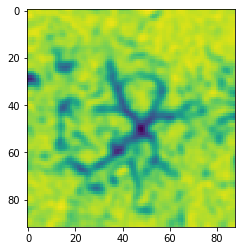

In [235]:
from skimage import filters
from scipy import ndimage as ndi
from skimage import img_as_float

def imshow_all(*images, titles=None):
    images = [img_as_float(img) for img in images]

    if titles is None:
        titles = [''] * len(images)
    vmin = min(map(np.min, images))
    vmax = max(map(np.max, images))
    ncols = len(images)
    height = 5
    width = height * len(images)
    fig, axes = plt.subplots(nrows=1, ncols=ncols,
                             figsize=(width, height))
    for ax, img, label in zip(axes.ravel(), images, titles):
        ax.imshow(img, vmin=vmin, vmax=vmax)
        ax.set_title(label)

        
mean_kernel = np.full((3, 3), 1/9)

bright_square = gray_section
smooth_mean = ndi.correlate(bright_square, mean_kernel)
sigma = 1
smooth = filters.gaussian(bright_square, sigma)

fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(smooth)
plt.show()

# imshow_all(bright_square, smooth_mean, smooth,
#            titles=['original', 'result of mean filter', 'result of gaussian filter'])

## Entropy and Complexity

In [10]:
import shearlexity
from FFST import shearletTransformSpect

/usr/local/lib/python3.7/site-packages/FFST/_fft.py:52: UserWarning: pyFFTW not found.  will try to use mklfft instead.
  warnings.warn("pyFFTW not found.  will try to use mklfft instead.")
/usr/local/lib/python3.7/site-packages/FFST/_fft.py:64: UserWarning: neither pyFFTW or mklfft found.  will use numpy.fft.
  warnings.warn("neither pyFFTW or mklfft found.  will use numpy.fft.")


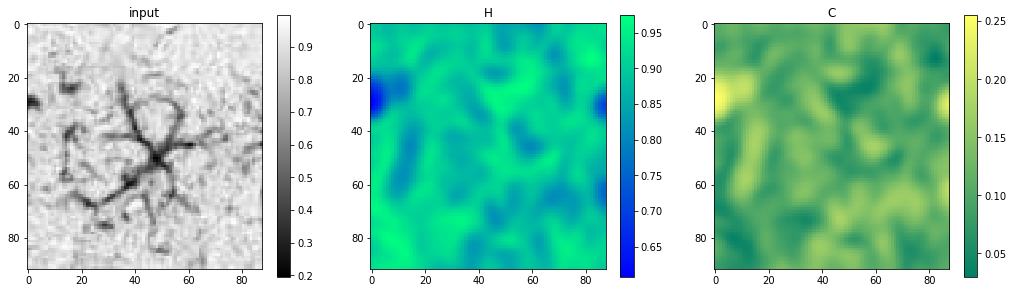

In [11]:
h,c = shearlexity.map_cecp(gray_section,3)
# f = gcf()
# ax = f.axes[0]
# ax.contour(Tr_profile,[1.],colors=['y'],)
# plt.show()

## Soma Detection

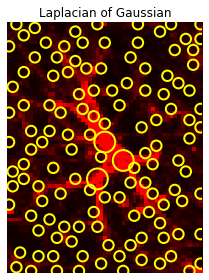

In [300]:
def get_blobs(cell_image):
    inverted_cell_image = invert(cell_image)
    # dab stain
    blobs_log = blob_log(inverted_cell_image, min_sigma=6, max_sigma=20, num_sigma=10, threshold=0.1, overlap=0.3)
    # confocal
#     blobs_log = blob_log(inverted_cell_image, min_sigma=1, max_sigma=20, num_sigma=10, threshold=0.1, overlap=0)
    # Compute radii in the 3rd column.
    blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)
    
    return blobs_log

fig, ax = plt.subplots(figsize=(4, 4))
ax.set_title('Laplacian of Gaussian')
ax.imshow(cell_image, interpolation='nearest')

blobs = get_blobs(cell_image)
# print(blobs)
for blob in blobs:
    y, x, r, sigma = blob
    c = plt.Circle((x, y), r, color='yellow', linewidth=2, fill=False)
    ax.add_patch(c)
    
ax.set_axis_off()
plt.tight_layout()
plt.show()

In [239]:
# find the blobs too close to border so as to eliminate them

def eliminate_border_blobs(blobs_log):
    blobs_dict = defaultdict()
    for i, blob in enumerate(blobs_log):
        blobs_dict[i] = blob
        y, x, r = blob
        image_border_x, image_border_y = image_gray.shape[0]/4, image_gray.shape[1]/4
        if x < image_border_x or x > 3*image_border_x or y < image_border_y or y > 3*image_border_y:
            blobs_dict.pop(i)
            
    return blobs_dict

In [240]:
# find the blob with highest intensity value

def centre_of_mass(blobs_dict):
    ixs = np.indices(image_gray.shape)
    xms = []
    yms = []
    ms = []
    for i, blob in blobs_dict.items():
        y, x, r = blob
        # Define an array of shape `[2, 1, 1]`, containing the center of the blob
        blob_center = np.array([y, x])[:, np.newaxis, np.newaxis]
        # Using the formula for a circle, `x**2 + y**2 < r**2`, generate a mask for this blob.
        mask = ((ixs - blob_center)**2).sum(axis=0) < r**2
        # Calculate the average intensity of pixels under the mask
        blob_avg_est = image_gray[mask].mean()
        yms.append(blob_avg_est*y)
        xms.append(blob_avg_est*x)
        ms.append(blob_avg_est)
        # print(f'Blob {i}: Centre {(x, y)}, average value: {blob_avg_est:.2f}')
    return (sum(yms)/sum(ms), sum(xms)/sum(ms))

In [288]:
def get_soma(cell_image):
    blobs = get_blobs(cell_image)
    soma_blobs = eliminate_border_blobs(blobs)
    if len(soma_blobs)==1:
        soma = list(soma_blobs.values())[0][:2]
    if len(soma_blobs)>1:
        soma = centre_of_mass(soma_blobs)

    return soma

In [289]:
soma = get_soma(cell_image)
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_title('Soma')
ax.imshow(cell_image, interpolation='nearest')

y, x = soma[0], soma[1]
c = plt.Circle((x, y), 1, color='yellow')
ax.add_patch(c)
    
ax.set_axis_off()
plt.tight_layout()
plt.show()

UnboundLocalError: local variable 'soma' referenced before assignment

In [285]:
soma

array([49., 49.])

## Thresholding

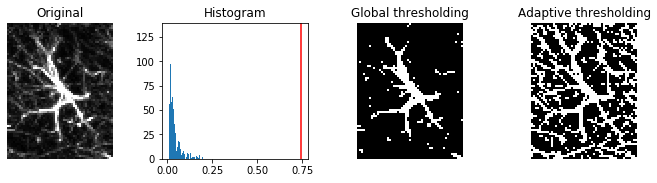

In [250]:
binary_global = gray_cell_image > threshold_otsu(gray_cell_image)

block_size = 21
binary_adaptive = gray_cell_image > threshold_local(gray_cell_image, block_size, offset=0)

fig, axes = plt.subplots(ncols=4, figsize=(12, 2.5))
ax = axes.ravel()
ax[0] = plt.subplot(1, 4, 1)
ax[1] = plt.subplot(1, 4, 2)
ax[2] = plt.subplot(1, 4, 3, sharex=ax[0], sharey=ax[0])
ax[3] = plt.subplot(1, 4, 4, sharex=ax[0], sharey=ax[0])

ax[0].imshow(gray_cell_image, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(gray_cell_image.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(threshold_otsu(gray_section), color='r')

ax[2].imshow(binary_global, cmap=plt.cm.gray)
ax[2].set_title('Global thresholding')
ax[2].axis('off')

ax[3].imshow(binary_adaptive, cmap=plt.cm.gray)
ax[3].set_title('Adaptive thresholding')
ax[3].axis('off')

plt.show()

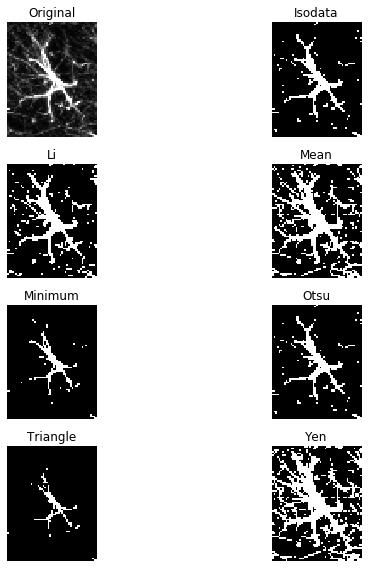

In [251]:
fig, ax = try_all_threshold(gray_cell_image, figsize=(10, 8), verbose=False)
plt.show()

## Surface Area

## Skeletonization

In [260]:
def skeletonization(thresholded_cell_image):
    # perform skeletonization
    return skeletonize(thresholded_cell_image)

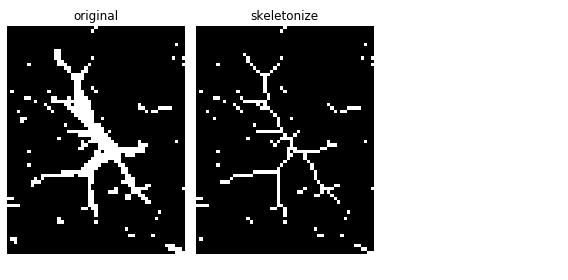

In [261]:
# display results
invert_thresholded_cell_image, skeleton = skeletonization(binary_global)

fig, axes = plt.subplots(1, 3, figsize=(8, 4), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(thresholded_cell_image, cmap=plt.cm.gray, interpolation='nearest')
ax[0].set_title('original')
ax[0].axis('off')

ax[1].imshow(skeleton, cmap=plt.cm.gray, interpolation='nearest')
ax[1].set_title('skeletonize')
ax[1].axis('off')

ax[2].axis('off')

fig.tight_layout()
plt.show()

In [268]:
def label_skeleton_components(skeleton):

    bw = closing(skeleton, square(1))
    # remove artifacts connected to image border
    cleared = clear_border(bw)
    # label image regions
    label_image = label(cleared)
    
    return label_image

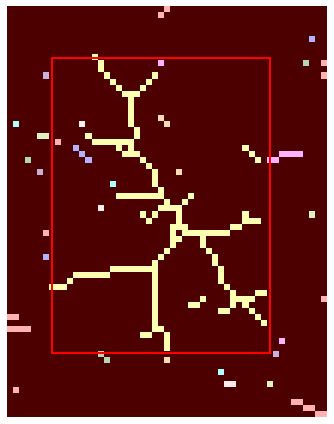

In [269]:
labelled_image = label_skeleton_components(skeleton)
image_label_overlay = label2rgb(labelled_image, image=skeleton)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

no_of_regions = 0
for region in regionprops(labelled_image):
    # take regions with large enough areas
    if region.area >= 50:
        no_of_regions+=1
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
#         ax.imshow(label_image[minr:maxr, minc:maxc])

ax.set_axis_off()
plt.tight_layout()
plt.show()

In [278]:
def remove_skeleton_noise(skeleton, min_size=50):
    labelled_image = label_skeleton_components(skeleton)
    astrocyte_skeleton = remove_small_objects(labelled_image, min_size)
    astrocyte_skeleton[astrocyte_skeleton > astrocyte_skeleton.mean()] = 1
    
    return astrocyte_skeleton

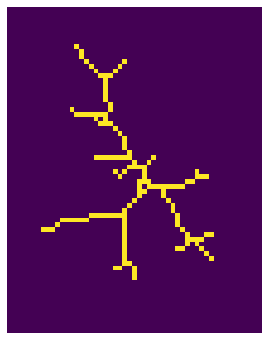

In [279]:
astrocyte_skeleton = remove_skeleton_noise(skeleton)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(astrocyte_skeleton)
ax.set_axis_off()
plt.show()

In [280]:
def distance(P1, P2):
    """
    computing the distance between 2 points
    """
    return ((P1[0] - P2[0])**2 + (P1[1] - P2[1])**2) ** 0.5

In [281]:
def soma_on_skeleton(astrocyte_skeleton):
    skeleton_pixel_coordinates = [(i, j) for (i, j), val in np.ndenumerate(astrocyte_skeleton) if val!=0]
    soma_on_skeleton = min(skeleton_pixel_coordinates, key=lambda x: distance(soma, x))
    
    return soma_on_skeleton

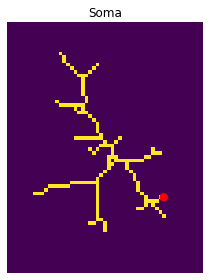

In [282]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_title('Soma')
ax.imshow(astrocyte_skeleton, interpolation='nearest')

y, x = soma_on_skeleton(astrocyte_skeleton)
c = plt.Circle((x, y), 1, color='red')
ax.add_patch(c)
    
ax.set_axis_off()
plt.tight_layout()
plt.show()

# Skeleton Analysis

In [31]:
import skan
from skan.pre import threshold
from skan import draw
from skan import skeleton_to_csgraph
from skan import Skeleton, summarize

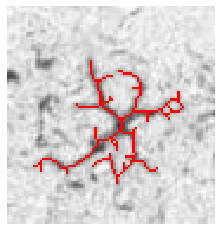

In [32]:
def plot_skeleton_overlay(cell_image):
    fig, ax = plt.subplots()
    draw.overlay_skeleton_2d(cell_image, astrocyte_skeleton, dilate=0, axes=ax);

## Total length

In [303]:
def total_length(astrocyte_skeleton):
    return np.sum(astrocyte_skeleton)

## Convex hull

In [343]:
def convex_hull(astrocyte_skeleton, plot=False):
    convex_hull = skimage.morphology.convex_hull_image(astrocyte_skeleton)
    if plot==True:
        fig, ax = plt.subplots()
        ax.set_axis_off()
        ax.imshow(convex_hull)
        
    return np.sum(convex_hull)

1180

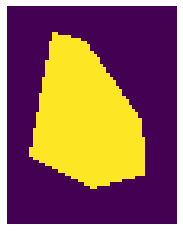

In [344]:
convex_hull(astrocyte_skeleton, plot=True)

## Branch Classification

Plots and array of lengths of primary, secondary and so on

No of forks

In [146]:
near = []
for i in range(skan.csr.Skeleton(final).n_paths):
    path_coords = skan.csr.Skeleton(final).path_coordinates(i)
    nearest = min(path_coords, key=lambda x: distance(soma_on_skeleton, x))
    near.append(nearest)

soma_on_path = min(near, key=lambda x: distance(soma_on_skeleton, x))
soma_node = [i for i,j in enumerate(skan.csr.Skeleton(final).coordinates) if all(soma_on_path==j)]
soma_node

[126]

/usr/local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


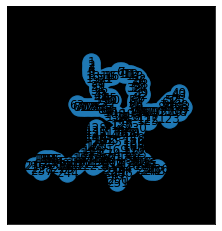

In [147]:
pixel_graph, coordinates, degrees = skeleton_to_csgraph(final)
fig, ax = plt.subplots()
draw.overlay_skeleton_networkx(pixel_graph, coordinates, image=final, axis=ax)

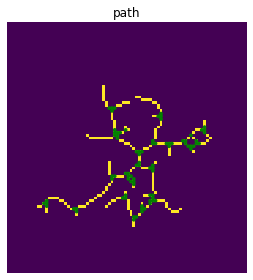

In [148]:
# just for displaying forks

fork_indices = np.where(degrees > [2])
fork_coordinates = zip(fork_indices[0], fork_indices[1])
plot(fork_coordinates, 'green')

In [126]:
from scipy.ndimage import label, generate_binary_structure

fork_image = np.where(degrees > [2], 1, 0)
s = generate_binary_structure(2,2)
labeled_array, num_forks = label(fork_image, structure=s)
print(num_forks)
labeled_array

20


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [129]:
branch_data = summarize(Skeleton(final, spacing=1))
branch_data

,skeleton-id,node-id-src,node-id-dst,branch-distance,branch-type,mean-pixel-value,stdev-pixel-value,image-coord-src-0,image-coord-src-1,image-coord-dst-0,image-coord-dst-1,coord-src-0,coord-src-1,coord-dst-0,coord-dst-1,euclidean-distance
0,1,1,23,9.772709,1,1.0,0.0,23.000000,35.000000,31.250000,38.000000,23.000000,35.000000,31.250000,38.000000,8.778525
1,1,6,24,13.672419,1,1.0,0.0,27.000000,47.000000,34.000000,55.750000,27.000000,47.000000,34.000000,55.750000,11.205467
2,1,16,23,6.772709,1,1.0,0.0,29.000000,44.000000,31.250000,38.000000,29.000000,44.000000,31.250000,38.000000,6.408003
3,1,23,27,9.695649,2,1.0,0.0,31.250000,38.000000,40.428571,39.714286,31.250000,38.000000,40.428571,39.714286,9.337288
4,1,24,32,2.750000,1,1.0,0.0,34.000000,55.750000,34.000000,53.000000,34.000000,55.750000,34.000000,53.000000,2.750000
5,1,24,35,10.639046,2,1.0,0.0,34.000000,55.750000,43.666667,53.333333,34.000000,55.750000,43.666667,53.333333,9.964172
6,1,25,40,3.015564,1,1.0,0.0,39.000000,71.750000,36.000000,72.000000,39.000000,71.750000,36.000000,72.000000,3.010399
7,1,25,34,5.578427,2,1.0,0.0,39.000000,71.750000,41.000000,67.000000,39.000000,71.750000,41.000000,67.000000,5.153882
8,1,25,37,11.606133,2,1.0,0.0,39.000000,71.750000,44.200000,67.000000,39.000000,71.750000,44.200000,67.000000,7.042904
9,1,27,30,3.739759,2,1.0,0.0,40.428571,39.714286,39.000000,43.000000,40.428571,39.714286,39.000000,43.000000,3.582839


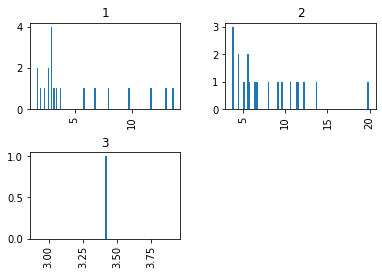

In [130]:
branch_data.hist(column='branch-distance', by='branch-type', bins=100);

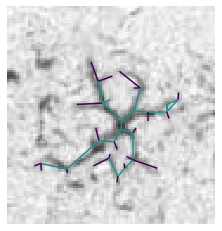

In [131]:
draw.overlay_euclidean_skeleton_2d(gray_section, branch_data, skeleton_color_source='branch-type');

In [445]:
branch_statistics = skan.csr.branch_statistics(pixel_graph)
branch_statistics

array([[  1.        ,  23.        ,   9.77270885,   1.        ],
       [  6.        ,  24.        ,  13.67241869,   1.        ],
       [ 16.        ,  23.        ,   6.77270885,   1.        ],
       [ 23.        ,  27.        ,   9.69564858,   2.        ],
       [ 32.        ,  24.        ,   2.75      ,   1.        ],
       [ 24.        ,  35.        ,  10.6390465 ,   2.        ],
       [ 40.        ,  25.        ,   3.01556444,   1.        ],
       [ 30.        ,  30.        ,   3.41421356,   2.        ],
       [ 25.        ,  34.        ,   5.57842712,   2.        ],
       [ 27.        ,  30.        ,   3.73975936,   2.        ],
       [ 63.        ,  27.        ,  11.73975936,   1.        ],
       [ 25.        ,  37.        ,  11.60613285,   2.        ],
       [ 34.        ,  37.        ,   3.83082276,   2.        ],
       [ 34.        ,  37.        ,   3.83082276,   2.        ],
       [ 27.        ,  48.        ,  11.47608051,   2.        ],
       [ 35.        ,  47

In [446]:
paths_list = skan.csr.Skeleton(final).paths_list()
paths_list

[[1, 2, 3, 4, 5, 8, 13, 19, 23],
 [6, 7, 9, 10, 11, 12, 17, 18, 22, 26, 28, 24],
 [16, 15, 14, 21, 20, 23],
 [23, 29, 31, 36, 38, 41, 44, 27],
 [24, 33, 32],
 [24, 39, 42, 46, 51, 60, 66, 79, 35],
 [25, 43, 40],
 [25, 53, 52, 61, 34],
 [25, 68, 82, 89, 107, 106, 37],
 [27, 59, 30],
 [27, 77, 76, 75, 74, 73, 72, 71, 70, 69, 63],
 [27, 83, 84, 90, 91, 108, 114, 48],
 [30, 45, 50, 30],
 [34, 80, 37],
 [34, 81, 37],
 [35, 94, 95, 96, 47],
 [35, 109, 116, 115, 48],
 [37, 102, 101, 100, 47],
 [37, 123],
 [47, 117, 122, 125],
 [48, 126, 127, 49],
 [49, 136, 143, 55],
 [49, 137, 138, 139, 54],
 [54, 130],
 [54, 148, 156, 160, 164, 167, 170, 172, 175, 58],
 [55, 153, 152, 151, 56],
 [55, 169],
 [56, 145, 142, 135, 131, 128],
 [56,
  161,
  165,
  168,
  171,
  173,
  177,
  176,
  187,
  197,
  196,
  210,
  222,
  221,
  220,
  65],
 [57, 174],
 [57, 189, 188, 199, 198, 211, 223],
 [57, 200, 212, 224, 232, 239, 245, 67],
 [58, 180, 179],
 [58, 204, 205, 206, 215, 227, 235, 241, 242, 243, 236],

In [447]:
def get_soma_branches(soma_node, paths_list):    
    soma_branches=[]
    for path in paths_list:
        if soma_node in path:
            soma_branches.append(path)
    return soma_branches

In [448]:
def eliminate_loops(branch_statistics, paths_list):
    loop_indexes=[]
    loop_branch_end_points=[]
    # eliminate loops from branch statistics
    boundary_points = (branch_statistics[0][0], branch_statistics[0][1])
    for branch_no, branch in enumerate(branch_statistics[1:]):
       # loops having slab trails with two different endpoints OR loops with same endpoints
        if boundary_points == (branch[0], branch[1]) or branch[0]==branch[1]:
            # for deleting the loop index from branch statistics
            loop_indexes.append(branch_no+1)
            # for deleting the paths from paths list by recognizing loop end points
            loop_branch_end_points.append((int(branch[0]), int(branch[1])))
        boundary_points = (branch[0], branch[1])
    new_branch_statistics = np.delete(branch_statistics, loop_indexes, axis=0)

    # eliminate loops from paths list
    path_indexes=[]
    for loop_end_points in loop_branch_end_points:
        for path_no, path in enumerate(paths_list):
            if loop_end_points[0]==path[0] and loop_end_points[1]==path[-1] or loop_end_points[0]==path[-1] and loop_end_points[1]==path[0]:
                path_indexes.append(path_no)
                break

    new_paths_list = np.delete(np.array(paths_list), path_indexes, axis=0)
                    
    return new_branch_statistics, new_paths_list

In [449]:
def branch_structure(junctions, branch_statistics):
    next_set_junctions = []
    next_set_branches = []
    terminal_branches=[]
    for junction in junctions:
        branches_travelled = []
        for branch_no, branch in enumerate(branch_statistics):
            if branch[0]==junction:
                if branch[3]==2:
                    next_set_junctions.append(branch[1])
                    for path in paths_list:
                        if branch[0]==path[0] and branch[1]==path[-1] or branch[0]==path[-1] and branch[1]==path[0]:
                            next_set_branches.append(path)
                            branches_travelled.append(branch_no)
                if branch[3]==1:
                    for path in paths_list:
                        if branch[0]==path[0] and branch[1]==path[-1] or branch[0]==path[-1] and branch[1]==path[0]:
                            terminal_branches.append(path)
                            next_set_branches.append(path)
                            branches_travelled.append(branch_no)
            elif branch[1]==junction:
                if branch[3]==2:
                    next_set_junctions.append(branch[0])
                    for path in paths_list:
                        if branch[0]==path[0] and branch[1]==path[-1] or branch[0]==path[-1] and branch[1]==path[0]:
                            next_set_branches.append(path)
                            branches_travelled.append(branch_no)
                if branch[3]==1:
                    for path in paths_list:
                        if branch[0]==path[0] and branch[1]==path[-1] or branch[0]==path[-1] and branch[1]==path[0]:
                            terminal_branches.append(path)
                            next_set_branches.append(path)
                            branches_travelled.append(branch_no)
        branch_statistics = np.delete(branch_statistics, branches_travelled, axis=0)
            
    return next_set_junctions, next_set_branches, terminal_branches, branch_statistics

In [450]:
def classify_branching_structure(soma_node, branch_statistics, paths_list):
    terminal_branches = []
    branching_structure_array = []
    # get branches containing soma node
    soma_branches = get_soma_branches(soma_node, paths_list)
    if len(soma_branches)>2:
        junctions = soma_node
        delete_soma_branch=False
    else:
        # collect first level/primary branches
        junctions = [soma_branches[0][0], soma_branches[0][-1]]
        delete_soma_branch=True
    
    # eliminate loops in branches and path lists
    branch_statistics, paths_list = eliminate_loops(branch_statistics, paths_list)
    
    while True:
        junctions, branches, terminal_branch, branch_statistics = branch_structure(junctions, branch_statistics)
        branching_structure_array.append(branches)
        terminal_branches.extend(terminal_branch)
        if len(junctions)==0:
            break

    if delete_soma_branch==True:
        branching_structure_array[0].remove(soma_branches[0])
        
    return branching_structure_array, terminal_branches

In [453]:
def get_primary_branches(soma_node, branch_statistics, paths_list):
    primary_branches = classify_branching_structure(soma_node, branch_statistics, paths_list)[0][0]
    no_of_primary_branches = len(primary_branches)
    avg_length_of_primary_branches = 0 if no_of_primary_branches == 0 else sum(map(len, primary_branches))/float(len(primary_branches))
    return primary_branches, no_of_primary_branches, avg_length_of_primary_branches

def get_secondary_branches(soma_node, branch_statistics, paths_list):
    secondary_branches = classify_branching_structure(soma_node, branch_statistics, paths_list)[0][1]
    no_of_secondary_branches = len(secondary_branches)
    avg_length_of_secondary_branches = 0 if no_of_secondary_branches == 0 else sum(map(len, secondary_branches))/float(len(secondary_branches))
    return secondary_branches, no_of_secondary_branches, avg_length_of_secondary_branches

def get_tertiary_branches(soma_node, branch_statistics, paths_list):
    tertiary_branches = classify_branching_structure(soma_node, branch_statistics, paths_list)[0][2]
    no_of_tertiary_branches = len(tertiary_branches)
    avg_length_of_tertiary_branches = 0 if no_of_tertiary_branches == 0 else sum(map(len, tertiary_branches))/float(len(tertiary_branches))
    return tertiary_branches, no_of_tertiary_branches, avg_length_of_tertiary_branches

def get_quatenary_branches(soma_node, branch_statistics, paths_list):
    quatenary_branches = classify_branching_structure(soma_node, branch_statistics, paths_list)[0][3:]
    quatenary_branches = [branch for branch_level in quatenary_branches for branch in branch_level]
    no_of_quatenary_branches = len(quatenary_branches)
    avg_length_of_quatenary_branches = 0 if no_of_quatenary_branches == 0 else sum(map(len, quatenary_branches))/float(len(quatenary_branches))
    return quatenary_branches, no_of_quatenary_branches, avg_length_of_quatenary_branches

def get_terminal_branches(soma_node, branch_statistics, paths_list):
    terminal_branches = classify_branching_structure(soma_node, branch_statistics, paths_list)[1]
    no_of_terminal_branches = len(terminal_branches)
    avg_length_of_terminal_branches = 0 if no_of_terminal_branches == 0 else sum(map(len, terminal_branches))/float(len(terminal_branches))
    return terminal_branches, no_of_terminal_branches, avg_length_of_terminal_branches

In [456]:
get_quatenary_branches(soma_node, branch_statistics, paths_list)

[[25, 68, 82, 89, 107, 106, 37], [34, 80, 37], [34, 81, 37], [37, 123], [62, 183, 184, 185, 186, 194, 195, 209, 219, 229, 65], [65, 244], [64, 213], [64, 246, 67], [25, 43, 40], [25, 53, 52, 61, 34], [62, 217, 216], [62, 228, 237], [57, 200, 212, 224, 232, 239, 245, 67], [67, 250, 251], [57, 174], [57, 189, 188, 199, 198, 211, 223]]


([[25, 68, 82, 89, 107, 106, 37],
  [34, 80, 37],
  [34, 81, 37],
  [37, 123],
  [62, 183, 184, 185, 186, 194, 195, 209, 219, 229, 65],
  [65, 244],
  [64, 213],
  [64, 246, 67],
  [25, 43, 40],
  [25, 53, 52, 61, 34],
  [62, 217, 216],
  [62, 228, 237],
  [57, 200, 212, 224, 232, 239, 245, 67],
  [67, 250, 251],
  [57, 174],
  [57, 189, 188, 199, 198, 211, 223]],
 16,
 4.1875)

In [428]:
# path_no = 30
# plot(skan.csr.Skeleton(final).path_coordinates(path_no), 'red')
# print(skan.csr.Skeleton(final).path(path_no))
# print(skan.csr.Skeleton(final).path_coordinates(path_no))

In [458]:
branch_array=classify_branching_structure(soma_node, branch_statistics, paths_list)[0]
color_branches=[]
for branch in branch_array:
    sub_branch=[]
    for paths in branch:
        sub_branch.extend(paths)
    color_branches.append(sub_branch)

color_branches_coords=[]
for branch in color_branches:
    sub_branch=[]
    for node in branch:
        sub_branch.append(coordinates[node])
    color_branches_coords.append(sub_branch)

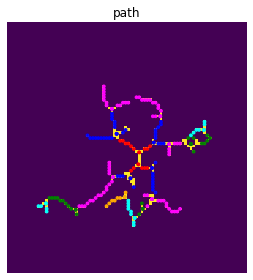

In [459]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_title('path')
ax.imshow(final, interpolation='nearest')

for i in color_branches_coords[0]:
    c = plt.Circle((i[1], i[0]), 0.5, color='red')
    ax.add_patch(c)
for i in color_branches_coords[1]:
    c = plt.Circle((i[1], i[0]), 0.5, color='blue')
    ax.add_patch(c)
for i in color_branches_coords[2]:
    c = plt.Circle((i[1], i[0]), 0.5, color='magenta')
    ax.add_patch(c)
for i in color_branches_coords[3]:
    c = plt.Circle((i[1], i[0]), 0.5, color='green')
    ax.add_patch(c)
for i in color_branches_coords[4]:
    c = plt.Circle((i[1], i[0]), 0.5, color='cyan')
    ax.add_patch(c)    
for i in color_branches_coords[5]:
    c = plt.Circle((i[1], i[0]), 0.5, color='orange')
    ax.add_patch(c) 
    
ax.set_axis_off()
plt.tight_layout()
plt.show()

If more than two objects are still there then black out the small one i.e with less pixel sum value

/usr/local/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:78: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


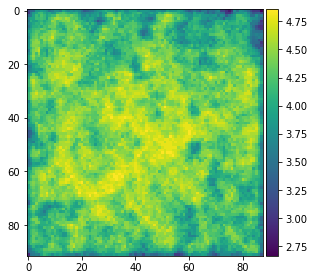

In [40]:
from skimage.filters.rank import entropy
from skimage.morphology import disk

ent = entropy(gray_section, disk(3))
io.imshow(ent)
io.show()

## Sholl Analysis

In [41]:
def sholl(cell_image, soma):

    concentric_coordinates = defaultdict(list) # {100: [(10,10), ..] , 400: [(20,20), ..]}
    concentric_coordinates_intensities = defaultdict(list)
    concentric_radiuses = [4, 8, 12, 16, 20, 24, 28, 32, 36]
    # concentric_radiuses = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
    
    for (x, y), value in np.ndenumerate(cell_image):
        for radius in concentric_radiuses:
            lhs = (x - soma[1])**2 + (y - soma[0])**2
            if abs((math.sqrt(lhs)-radius)) < 0.9:
                concentric_coordinates[radius].append((x, y))
                concentric_coordinates_intensities[radius].append(value)

    return concentric_coordinates, concentric_coordinates_intensities

/usr/local/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:75: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


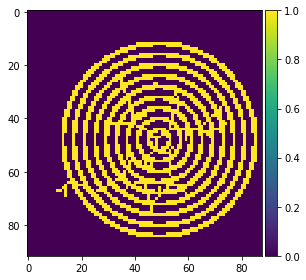

In [42]:
# final = skimage.img_as_ubyte(final)
inverted_cell_image = copy.deepcopy(final)
concentric_coordinates, concentric_intensities = sholl(inverted_cell_image, soma_on_skeleton)
for radius, coordinates in concentric_coordinates.items():
    for coord in coordinates:
        cell_image_with_circles = inverted_cell_image
        cell_image_with_circles[coord[0],coord[1]]=1.5
io.imshow(cell_image_with_circles)
io.show()

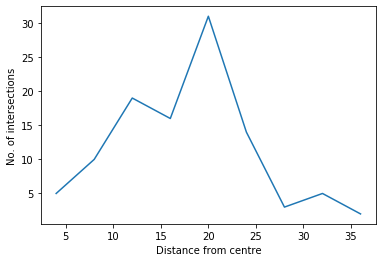

In [92]:
# binary = final > threshold_otsu(final)
concentric_coordinates, concentric_intensities = sholl(final, soma_on_skeleton)
    
xs = []
ys = []
for rad, val in concentric_intensities.items():
    avg = sum(val)
    xs.append(rad)
    ys.append(avg)

order = np.argsort(xs)
x = np.array(xs)[order]
y = np.array(ys)[order]

plt.plot(x, y)
plt.xlabel("Distance from centre")
plt.ylabel("No. of intersections") 
plt.show()

In [116]:
# Get the indices of maximum element in numpy array
peak_value_radius = x[np.argmax(y)]
peak_value = y[np.argmax(y)]
enclosing_radius = x[len(y) - (y!=0)[::-1].argmax() - 1]
skewness = skew(y)
# schoenen_ramification_index = 

In [117]:
skewness

0.878489037172818

In [53]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [62]:
x_data = x.reshape((-1, 1))
y_data = y

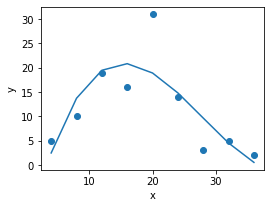

coefficient of determination: 0.666894669001411
skewness -0.247045339470021


In [121]:
# Linear
x_ = PolynomialFeatures(degree=3, include_bias=False).fit_transform(x_data)

# create a linear regression model
model = LinearRegression().fit(x_, y)

# predict y from the data
x_new = x
y_new = model.predict(x_)

# plot the results
plt.figure(figsize=(4, 3))
ax = plt.axes()
ax.scatter(x_data, y_data)
ax.plot(x_new, y_new)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.axis('tight')
plt.show()

# def f(x):
    
    
    
polynomial_coefficient_of_determination = model.score(x_, y)
# critical_radius = 
# critical_value = scipy.optimize.minimize_scalar(lambda x: -f(x), bounds=[x[0],x[1]], method='bounded')
skewness = skew(y_new)

print('coefficient of determination:', polynomial_coefficient_of_determination)
print('skewness', skewness)

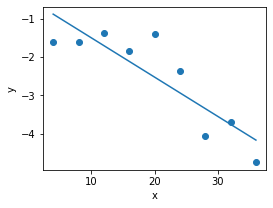

coefficient of determination: 0.7568510647233614
intercept: -0.47253934521767693
slope: [0.10257346]


In [86]:
# Semi-log

# no. of intersections/circumference
normalized_y = np.log(y/(2*math.pi*x))
model = LinearRegression().fit(x_data, normalized_y)

# predict y from the data
x_new = x
y_new = model.predict(x_data)

# plot the results
plt.figure(figsize=(4, 3))
ax = plt.axes()
ax.scatter(x_data, normalized_y)
ax.plot(x_new, y_new)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.axis('tight')
plt.show()

semi_log_r2 = model.score(x_data, normalized_y)
semi_log_regression_intercept = model.intercept_
semi_log_sholl_regression_coefficient = -model.coef_

print('coefficient of determination:', semi_log_r2)
print('intercept:', semi_log_regression_intercept)
print('slope:', semi_log_sholl_regression_coefficient)

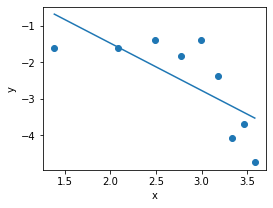

coefficient of determination: 0.5229517178859497
intercept: 1.1232998688830351
sholl regression coefficient: [1.29856624]


In [88]:
# Log-log profiles

# no. of intersections/circumference
normalized_y = np.log(y/(2*math.pi*x))
normalized_x = np.log(x_data)
model = LinearRegression().fit(normalized_x, normalized_y)

# predict y from the data
x_new = normalized_x
y_new = model.predict(normalized_x)

# plot the results
plt.figure(figsize=(4, 3))
ax = plt.axes()
ax.scatter(normalized_x, normalized_y)
ax.plot(x_new, y_new)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.axis('tight')
plt.show()

log_log_r2 = model.score(normalized_x, normalized_y)
log_log_regression_intercept = model.intercept_
log_log_sholl_regression_coefficient = -model.coef_

print('coefficient of determination:', log_log_r2)
print('intercept:', log_log_regression_intercept)
print('sholl regression coefficient:', log_log_sholl_regression_coefficient)

In [89]:
determination_ratio = semi_log_r2/log_log_r2

if determination_ratio>1:
    normalization_method="Semi-log"
    coefficient_of_determination = semi_log_r2
    sholl_regression_coefficient = semi_log_sholl_regression_coefficient
    regression_intercept = semi_log_regression_intercept
else:
    normalization_method="Log-log"
    coefficient_of_determination = log_log_r2
    sholl_regression_coefficient = log_log_sholl_regression_coefficient
    regression_intercept = log_log_regression_intercept

In [90]:
critical_radius
critical_value
# enclosing_radius
skewness
schoenen_ramification_index

normalization_method
polynomial_coefficient_of_determination
coefficient_of_determination
sholl_regression_coefficient
regression_intercept

-0.47253934521767693

In [72]:
# def plot_folder_avg():
#     avg_intensities = defaultdict(list)
#     for file in os.listdir('.'):
#         cell_image = io.imread(file)
#         gray_cell_image = rgb2gray(cell_image)
#         inverted_cell_image = skimage.util.invert(gray_cell_image)
#         concentric_coordinates, concentric_intensities = sholl(inverted_cell_image, soma)

#         for radius, value in concentric_intensities.items():
#             avg_intensities[radius].append(value)
#     x = []
#     y = []

#     for rad, val in avg_intensities.items():
#         all_intensity_vals = [i[0] for i in val]
#         avg = sum(all_intensity_vals)/ len(val)
#         x.append(rad)
#         y.append(avg)
        
#     return x, y

# os.chdir("/home/user/Desktop/small")
# x, q = plot_folder_avg()

# os.chdir("/home/user/Desktop/large")
# x, z = plot_folder_avg()

# plt.plot(x, q)
# plt.plot(x, z)
# plt.legend(['y = small', 'y = large'], loc='upper right')
# plt.xlabel("Distance from centre")
# plt.ylabel("Intensity")
# plt.show()

## PCA

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
def get_features(folder_name):
    cell_images=[]
    for file in os.listdir(folder_name):
        cell_image = io.imread(file)
        gray_cell_image = rgb2gray(cell_image)
        cell_images.append(gray_cell_image)
    
    dataset=[]
    for cell_image in cell_images:
        features=[]
        features.append(total_length(cell_image))
        features.append(no_of_forks(cell_image))
        features.append(average_primary_branches(cell_image))
        features.append(average_secondary_branches(cell_image))
        features.append(average_tertiary_branches(cell_image))
        features.append(average_quaternary_branches(cell_image))
        features.append(average_terminal_branches(cell_image))
        features.append(entropy(cell_image))
        features.append(complexity(cell_image))
        features.append(sholl.critical_radius(cell_image))
        features.append(sholl.critical_value(cell_image))
        features.append(sholl.enclosing_radius(cell_image))
        features.append(sholl.schoenen_ramification_index(cell_image))
        features.append(sholl.polynomial_r2(cell_image))
        features.append(sholl.polynomial_skewness(cell_image))
        features.append(sholl.sholl_regression_coefficient(cell_image))
        features.append(sholl.sholl_regression_r2(cell_image))
        features.append(sholl.regression_intercept(cell_image))
        
        dataset.append(features)

In [ ]:
pca = PCA(2)
# fit on data
pca.fit(A)
# access values and vectors
print(pca.components_)
print(pca.explained_variance_)
# transform data
B = pca.transform(A)
print(B)

## Confocal

In [ ]:
# os.chdir("/home/user/Desktop")

In [ ]:
# confocal_section = io.imread("confocal images/SingleGreenchannel.tif")                                   
# confocal_gray_section = rgb2gray(confocal_section) 

In [ ]:
# binary_global = confocal_gray_section > threshold_triangle(confocal_gray_section)
# data = invert(binary_global)

# # display results
# fig, ax = plt.subplots(figsize=(9,5))
# ax.imshow(data, cmap=plt.cm.gray, interpolation='nearest')
# ax.set_title('original')
# ax.set_axis_off()
# fig.tight_layout()
# plt.show()

In [ ]:
# bw = closing(binary_global, square(1))

# # remove artifacts connected to image border
# cleared = clear_border(bw)

# # label image regions
# label_image = label(cleared)
# image_label_overlay = label2rgb(label_image, image=data)

# fig, ax = plt.subplots(figsize=(10, 6))
# ax.imshow(image_label_overlay)

# for region in regionprops(label_image):
#     # take regions with large enough areas
#     if region.area >= 400:
#         # draw rectangle around segmented coins
#         minr, minc, maxr, maxc = region.bbox
#         rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
#                                   fill=False, edgecolor='red', linewidth=2)
#         ax.add_patch(rect)

# ax.set_axis_off()
# plt.tight_layout()
# plt.show()

In [ ]:
# from skimage import morphology

In [ ]:
# boxed_astrocyte = label_image[minr:maxr, minc:maxc]
# final = morphology.remove_small_objects(boxed_astrocyte, 50)
# fig, ax = plt.subplots(figsize=(10, 6))
# ax.imshow(final)
# ax.set_axis_off()
# plt.show()

In [ ]:
# import mahotas

# # nuclear = mahotas.imread(nuclear_path)
# nuclear = mahotas.gaussian_filter(binary_global, 3.)
# threshed  = (nuclear > nuclear.mean())
# distances = mahotas.stretch(mahotas.distance(threshed))
# Bc = np.ones((9,9))

# maxima = mahotas.morph.regmax(distances, Bc=Bc)
# spots,n_spots = mahotas.label(maxima, Bc=Bc)
# surface = (distances.max() - distances)
# areas = mahotas.cwatershed(surface, spots)
# areas *= threshed



# import random
# from matplotlib import colors as c
# colors = list(map(plt.cm.jet,range(0, 256, 4)))
# random.shuffle(colors)
# colors[0] = (0.,0.,0.,1.)
# rmap = c.ListedColormap(colors)
# plt.imshow(areas, cmap=rmap)
# plt.show()